# DCNet - A simple LSTM-RNN for generating sequence consensus

First, we need some boilerplate code to load the PyTorch and other modules.

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

torch.manual_seed(42)

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

Here we define the simple DCNet class as subclass of `torch.nn.Module`.

In [3]:
class DCNet(nn.Module):

    def __init__(self, hidden_dim, layer1_dim, layer2_dim):
        super(DCNet, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(4, hidden_dim) 
        self.linear1 = nn.Linear(hidden_dim, layer1_dim)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(layer1_dim, layer2_dim)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(layer2_dim, 4)
        self.hidden_init_values = None
        self.hidden = self.init_hidden()
        nn.init.xavier_uniform(self.linear1.weight)
        nn.init.xavier_uniform(self.linear2.weight)
        nn.init.xavier_uniform(self.linear3.weight)
        
    def init_hidden(self):
        if self.hidden_init_values == None:
            self.hidden_init_values = (autograd.Variable(torch.randn(1, 1, self.hidden_dim)),
                                       autograd.Variable(torch.randn(1, 1, self.hidden_dim)))
        return self.hidden_init_values

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        tmp1 = self.relu1(self.linear1(lstm_out.view(len(seq), -1)))
        tmp2 = self.relu2(self.linear2(tmp1))
        _out = self.linear3(tmp2)
        base_out = _out
        return base_out


We define a couple utility functions for encoding DNA bases to vectors and simulate sequencing errors.

In [4]:
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')

bmap = {"A":0, "C":1, "G":2, "T":3}
def one_hot(b):
    t = [[0,0,0,0]]
    i = bmap[b]
    t[0][i] = 1
    return t

print("one-hot encoding for DNA bases")
print("A:", one_hot("A"))
print("C:", one_hot("C"))
print("G:", one_hot("G"))
print("T:", one_hot("T"))


one-hot encoding for DNA bases
A: [[1, 0, 0, 0]]
C: [[0, 1, 0, 0]]
G: [[0, 0, 1, 0]]
T: [[0, 0, 0, 1]]


In [5]:
def sim_error(seq, pi=0.05, pd=0.05, ps=0.01):
    """
    Given an input sequence `seq`, generating another
    sequence with errors. 
    pi: insertion error rate
    pd: deletion error rate
    ps: substitution error rate
    """
    out_seq = []
    for c in seq:
        while 1:
            r = random.uniform(0,1)
            if r < pi:
                out_seq.append(random.choice(["A","C","G","T"]))
            else:
                break
        r -= pi
        if r < pd:
            continue
        r -= pd
        if r < ps:
            out_seq.append(random.choice(["A","C","G","T"]))
            continue
        out_seq.append(c)
    return "".join(out_seq)

Generate a random sequence of length 220 as our original teamplate sequences.

In [6]:
seq = [random.choice(["A","C","G","T"]) for _ in range(220)]
print("".join(seq))
# convert the `seq` to a PyTorch tensor

TAGATATGGCTAGAAGATCTGTTAACTCGCATAAGGATCCGCGGTCGCCCCCTCCTAGTCTTATTAAACACATAGTGCCACTACACATGAATTGTGATGAATAGCTTGAGCTTGGGAATCAATCTTAATGTTACGTCCATTTAGGTACCGTCCCAGGAATGGTGTTGACAGTAGCCACACTTTTCCTCTTGGCGGTGCACCAATGTCGGTCGAATAGCTG


In [7]:
seq_t = Variable(torch.FloatTensor([one_hot(c) for c in seq])).cuda()

Simulate 20 erroneous sequences with insertion error at 5%, deletion errors at 5% and subsitution error at 1%.

In [8]:
seqs = [sim_error(seq, pi=0.05, pd=0.05, ps=0.01) for _ in range(20)]
seqs_t = [Variable(torch.FloatTensor([one_hot(c) for c in s])).cuda()  for s in seqs]

Initialize the DCNet.

In [9]:
dcnet = DCNet(32, 12, 12)
dcnet.cuda()
dcnet.zero_grad()
dcnet.hidden = dcnet.init_hidden()

# initial the paramerters in the DCNet
for name, param in dcnet.named_parameters():
    if 'bias' in name:
        nn.init.constant(param, 0.0)
    elif 'weight' in name:
        nn.init.xavier_normal(param)

C:\Users\flyku\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\flyku\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()
C:\Users\flyku\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\flyku\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\flyku\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


Set up the loss function and SGD optimizer.

In [10]:
#loss_function = nn.L1Loss()
loss_function = nn.MSELoss()
lr = 0.1
optimizer = optim.SGD(dcnet.parameters(), lr=lr)

The following loop train the DCnet using the noisy sequences. We also lowe the learning rate `lr` every 250 epoches

In [14]:
range_ = (1, 200)
mini_batch_size = 5
for epoch in range(750):
    for i in range(int(len(seqs_t)/mini_batch_size)):
        loss = 0
        s, e = range_
        for seq2 in random.sample(seqs_t, mini_batch_size):
            dcnet.hidden = dcnet.init_hidden()
            dcnet.zero_grad()
            seq2 = seq2[s-1:e]
            seq_ = seq2.view(-1,4)
            out = dcnet(seq_)
            loss += loss_function(out[:-1], seq_[1:])
        loss.backward()
        optimizer.step()
    if epoch % 250==0:
        print("epoch:", epoch, "loss:", loss.cpu().data/mini_batch_size, "learning rate:", lr)
        lr *= 0.95
        optimizer = optim.SGD(dcnet.parameters(), lr=lr)

epoch: 0 loss: tensor(0.1478, device='cpu') learning rate: 0.08145062499999998
epoch: 250 loss: tensor(0.1268, device='cpu') learning rate: 0.07737809374999999
epoch: 500 loss: tensor(0.1056, device='cpu') learning rate: 0.07350918906249998


We can visualize the input and output tensors after we send the whole original template into the DCNet to reconstruct the output tensor. 

In [15]:
import numpy as np
dcnet.hidden = dcnet.init_hidden()
xout = dcnet(seq_t[:250])
x1 = xout[:-1].cpu().data.numpy() 
xx1=np.transpose(seq_t[1:250,0,:].data.cpu().numpy())
xx2=np.transpose(x1)


The cell below plots three matrices. The first one is from the original template. The second one is the reconstruction from the the DCNet using the whole initial template as input. The third one is the differences between the two matrices. In some cases, if the training of the DCNet is not properly converged, you might see a lot of spot lighting up in the third matrix.

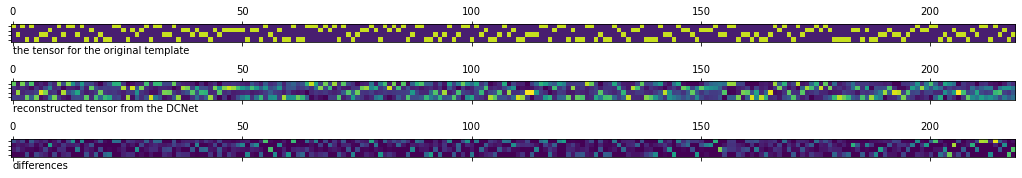

In [16]:
plt.figure(figsize=(18,3))
plt.subplot(3,1,1)
plt.matshow(xx1, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"the tensor for the original template")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,2)
plt.matshow(xx2, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"reconstructed tensor from the DCNet")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,3)
plt.matshow(xx1-xx2, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"differences");
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([]);

The following code snippet using DCNet to generate a consensus sequence with only the first base in the template. 

In [17]:
dcnet.hidden = dcnet.init_hidden()
base_t= Variable(torch.FloatTensor([one_hot(seq[0])])).cuda()

consensus = []

for _ in range(201):
    xout = dcnet(base_t)
    next_t = [0,0,0,0]
    next_t[np.argmax(xout.cpu().data.numpy())]=1
    consensus.append(next_t)
    base_t= Variable(torch.FloatTensor([next_t])).cuda()
consensus = np.array(consensus)
consensus = consensus.transpose()

Let's compare the generated consensus to the original template. If we have generate the consensus perfectly matching the original template, the elements of the third matrix will be all zeros (blue color).

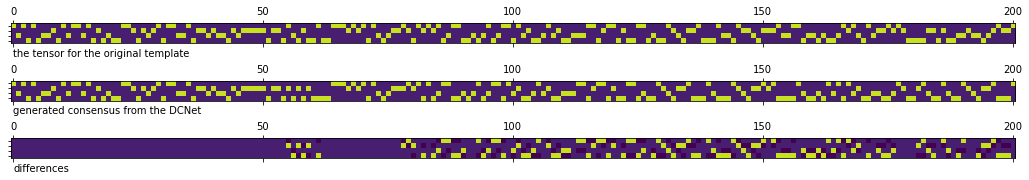

In [18]:

plt.figure(figsize=(18,3))
plt.subplot(3,1,1)
plt.matshow(xx1[:,0:201], vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"the tensor for the original template")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,2)
plt.matshow(consensus, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"generated consensus from the DCNet")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,3)
plt.matshow(consensus-xx1[:,0:201], vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,6,"differences")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([]);

Let's try an interesting experiment to see if the DCNet can be used to find a homologous sub-sequence embedding in a long strech of sequences. We create a new sequence that embed the oringal template sequences with some noises inside other random sequences.  If we send the full sequence to DCNet, We expect that the reconstructed sequence will have less different in the region that is homologuous to the original templae.

In [19]:
dcnet.hidden = dcnet.init_hidden()

seq_prefix = [random.choice(["A","C","G","T"]) for _ in range(100)]
seq_suffix = [random.choice(["A","C","G","T"]) for _ in range(100)]
seq_t2 = Variable(torch.FloatTensor([one_hot(c) for c in seq_prefix+list(sim_error(seq, pi=0.02, pd=0.02, ps=0.02))+seq_suffix])).cuda()

xout = dcnet(seq_t2)
x1 = xout[:-1].cpu().data.numpy()
xx1=np.transpose(seq_t2[1:,0,:].data.cpu().numpy())
xx2=np.transpose(x1)


The following code plot the reconstrution and the difference to the input sequence. (You might need to double click on the the plot to enlarge the plot to see it clearer.). The sequence used to train the DCNet is embedded roughly from base 100 to 300. Once can see the difference over that region is smaller than other regions. However, the convergence may not happend immediately from base 100, as it could take a while for DCNet recognized the network has "seen" some similar sequences. 

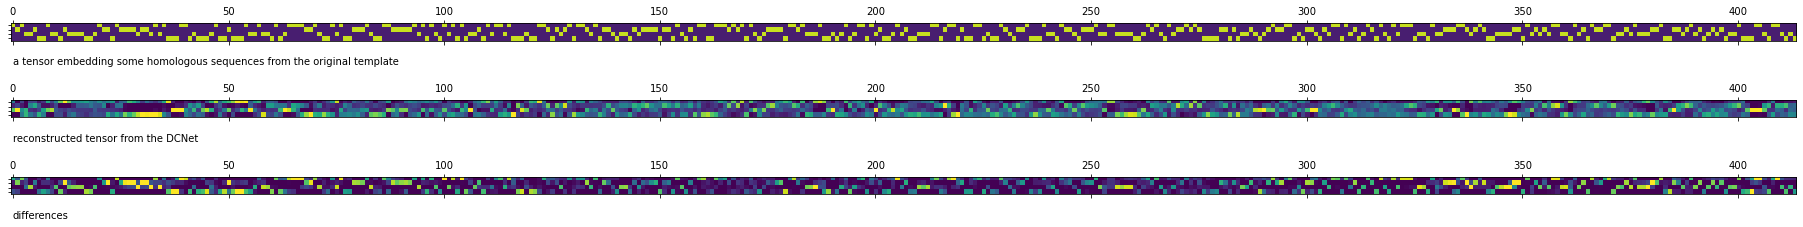

In [20]:
plt.figure(figsize=(32,4))
plt.subplot(3,1,1)
plt.matshow(xx1, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,9,"a tensor embedding some homologous sequences from the original template")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,2)
plt.matshow(xx2, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,9,"reconstructed tensor from the DCNet")
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])

plt.subplot(3,1,3)
plt.matshow(xx1-xx2, vmin=-0.1, vmax=1.1, fignum=False)
plt.text(0,9,"differences");
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([]);